## Regression With Grouped Data

Not all data points are created equal. If we look again at our ENEM dataset, we trust much more in the score of big schools than in the ones from small schools. This is not to say that big schools are better or anything. It is just due to the fact that they have way less variance.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

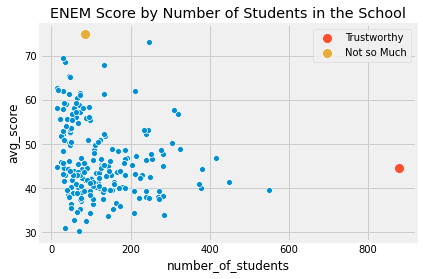

In [2]:
np.random.seed(876)
enem = pd.read_csv("./data/enem_scores.csv").sample(200)
# plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

In the data above, intuitively, points to the left should have less impact in my model than points to the right. In essence, points to the right are actually lots of other data points grouped into a single one. If we could unbundle them and run a linear regression on the ungrouped data, they would indeed contribute much more to the model estimation than an unbundled point in the left. 

Grouped data like the one above are extremely common in data analysis. One reason for that is confidentiality. Governments and firms can't give away personal data because that would violate data privacy requirements they have to follow. So, of they need to export data to an outside researcher, they can only do it by means of grouping the data. This way, individuals get grouped together and are no longer uniquely identifiable.

Fortunately, regression can handle those kinds of data pretty well. To understand how, let's first take some ungrouped data like the one we had on wage and education. It contains one line per worker, so we know the wage for each individual in this dataset and also how many years of education he or she has.

In [3]:
wage = pd.read_csv("./data/wage.csv").dropna()[["wage", "lhwage", "educ", "IQ"]]
wage.head()

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74
6,600,2.708050,10,91


If we run a regression model to figure out how education is associated with log hourly wages, we get the following result.

In [4]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
educ,0.0536,0.008,7.114,0.000,0.039,0.068


However, let's pretend for a moment that this data was under some confidentiality constraint. The provider of it was not able to give individualised data. So we ask him instead to group everyone by years of education and give us only the mean log hourly wage and the number of individuals in each group. This leaves us with only 10 data points. No reason to worry!

In [5]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

,educ,lhwage,count
0,9,2.679533,4
1,10,2.730512,21
2,11,2.878807,25
3,12,2.949520,270
4,13,3.101693,56
5,14,3.007821,53
6,15,3.176634,32
7,16,3.176659,121
8,17,3.259375,35
9,18,3.178160,46


But fear not! Regression doesen't need big data to work! What we can do is provide weights to our linear regression model. This way, it will consider groups with higher sample size more than the small groups. Notice how I've replaced the `smf.ols` with `smf.wls`, for weighted least squares. It's hard to notice, but it will make all the difference.

In [6]:
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.108,21.321,0.000,2.058,2.557
educ,0.0536,0.008,6.867,0.000,0.036,0.072


Notice how the parameter estimate of `educ` in the grouped model is exactly the same as the one with the the ungrouped data. Also, even with only 10 data points, we've manage to get a statistically significant coefficient! However, the standard error is a bit larger, as is the t statistics. That's because some information about the variance is lost, so we have to be more conservative. Once we group the data, we don't know how the variance is within each group. Compare the results above with what we would have with the non weighted model bellow.

In [7]:
model_3 = smf.ols('lhwage ~ educ', data=group_wage).fit()
model_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.1739,0.111,19.497,0.000,1.917,2.431
educ,0.0622,0.008,7.702,0.000,0.044,0.081


The parameter estimate is larger. What is happening here is that the regression is placing equal weight for all points. If we plot the model along the grouped points, we see that the non weighted model is given more importance to  small points in the lower right than it should. As a consequence, the line has a higher slope.

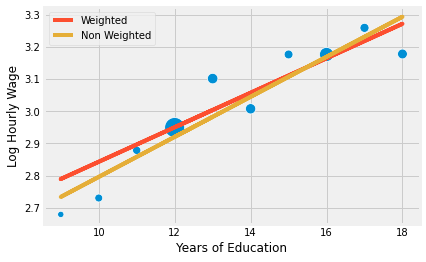

In [8]:
sns.scatterplot(x="educ", y = "lhwage", size="count", legend=False, data=group_wage, sizes=(40, 400))
plt.plot(wage["educ"], model_2.predict(wage["educ"]), c="C1", label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

The bottom line is that regression is this marvellous tool that works both we individual or aggregated data, but you have to use weights in this last case. To use weighted regression you need mean statistics. Not sum, not standard deviation, but means! For both the covariates and the dependent variable. With the exception of the bivariate case, the result of weighted regression with grouped data won't match exactly that of regression in ungrouped data, but it will be pretty similar. I'll finish with a final example using additional covariates in a grouped data model.

In [9]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "IQ":"mean", "count":"count"})
              .reset_index())

model_4 = smf.ols('lhwage ~ educ + IQ', data=group_wage).fit()
print("Number of observations:", model_4.nobs)
model_4.summary().tables[1]

Number of observations: 10.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.9747,0.427,4.629,0.002,0.966,2.983
educ,0.0464,0.034,1.377,0.211,-0.033,0.126
IQ,0.0041,0.008,0.486,0.642,-0.016,0.024


## Regression for Dummies

We've already dealt with a simple for of dummy regression when deatling with A/B testing. When the dependent variable is binary, as is often the case with treatment indicators, regression captued the ATE perfectly. That is because in this particular case, the CEF IS linear. Namely, we can define \\(E[Y_i|T_i=0]=\alpha\\) and \\(E[Y_i|T_i=1] = \alpha + \beta\\), which leads to the following CEF

$
E[Y_i|T_i] =  E[Y_i|T_i=0] + \beta T_i = \alpha + \beta T_i
$

and \\(\beta\\) is the difference in means or the ATE in the case or random data

$
\beta = [Y_i|T_i=1] - [Y_i|T_i=0]
$

To exemplify this, lets again consider the impact of education on hourly wage.

In [10]:
wage = (pd.read_csv("./data/wage.csv")
        .assign(hwage=lambda d: d["wage"] / d["hours"])
        .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
        [["hwage", "educ", "IQ_bins"]])

wage.head()

,hwage,educ,IQ_bins
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


But, this time, we will not trat education as a continous integer varibale. Instead, we will consider each year of education as a category. 

In [11]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775


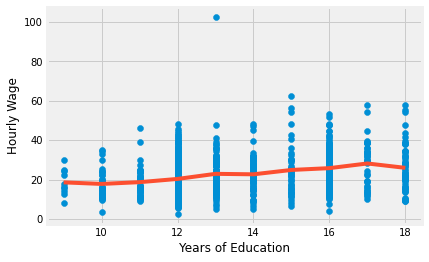

In [12]:
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");

First of all notice how this removes any assumption about the functional form of how education affects wages. We don't need to worry about logs anymore. In essence, this model is completely non-parametric. All it does is compute sample averages of wage for each year of education. This can be seen in the plot above, where the fitted line doesn't has a particular form. Instead, is the interpolation the sample means for each year of education. We can also see that by reconstructing one parameter estimate, for instance, that of 17 years of education. The model fitted above finds `9.5905` as the estimate for this parameter. Bellow, we can see how it is just the difference between the baseline years of education (9) and the individuals with 17 years

$
\beta_{17} = E[Y|T=17]-E[Y|T=9]
$

In [13]:
t1 = wage.query("educ==17")["hwage"]
t0 = wage.query("educ==9")["hwage"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.590472362353516


If we include more dummy covariates in the model, the parameters on education become a weighted average of the effect on each dummy group:

$
E\{ \ (E[Y_i|T=1, Group_i] - E[Y_i|T=0, Group_i])w(Group_i) \ \}
$

\\(w(Group_i)\\) is not exactly, but is proportional to the variance of the treatment in the group \\(Var(T_i|Group_i)\\). One natural question that arise from this is why not use the full non-parametric estimator, where the group weight is the sample size? This indeed is a valid estimator, but it is not what regression does. By using the treatment variance, regression is placing more weight is groups where the treatment varies a lot. This makes intuitive sense. If the treatment was almost constant (say 1 treated and everyone else untreated), it doesn't matter its sample size, it wouldn't provide much information about the treatment effect.

In [14]:
model_dummy_2 = smf.ols('hwage ~ C(educ) + C(IQ_bins)', data=wage).fit()
model_dummy_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.4178,2.991,6.158,0.000,12.548,24.288
C(educ)[T.10],-1.2149,3.392,-0.358,0.720,-7.872,5.442
C(educ)[T.11],-0.4687,3.332,-0.141,0.888,-7.008,6.070
C(educ)[T.12],0.3400,3.059,0.111,0.912,-5.664,6.344
C(educ)[T.13],2.4103,3.206,0.752,0.452,-3.882,8.702
C(educ)[T.14],1.8040,3.238,0.557,0.578,-4.551,8.159
C(educ)[T.15],3.8599,3.369,1.146,0.252,-2.752,10.472
C(educ)[T.16],4.4060,3.171,1.390,0.165,-1.817,10.629
C(educ)[T.17],6.7470,3.422,1.971,0.049,0.030,13.464
C(educ)[T.18],4.3463,3.332,1.304,0.192,-2.194,10.886


## Key Ideas

We started this section by looking how some data points are more important than others. Namely, those with higher sample size and lower variance should be given more weight when estimating a linear model. Then, we looked at how linear regression can even handle grouped anonymised data with elegance, provided we use sample weights in our model.

Next, we moved to dummy regression. We saw how it can be made a non parametric model that place no assumptions whatsoever on the functional form of how that the treatment impact the outcome. We then explored the intuition behind dummy regression

## References

I like to think of this entire series is a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this though year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)